# Model testing 

## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

import cv2

import sys
sys.path.insert(0, 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris')
#from autotetris.dataloader import RoofDataSet
from lib.dataloader import RoofDataSet, Transforms
from lib.modeltraining import Resnet18, Resnet50, Resnet18_GAP, SolarPanelDetector, VarMSEloss, train_model, test_model, test_model_heat

## Import path

In [2]:
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01/meta_data.hdf'
input_path = path

## Data Loading

In [3]:
dataset = RoofDataSet(path, transform=Transforms(new_size=(256,256)), mode = "constant")
imp_path = dataset.image_paths +  "/"+dataset.id[0]+"-b15-otovowms.jpeg"
image = cv2.imread(imp_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#%%
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


## Train test split

In [4]:
train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])


len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

In [5]:
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(x_.to("cpu") for x_ in default_collate(x)))
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The length of Train set is 14304
The length of Valid set is 1589
The length of Test set is 1765


## Model Testing

## Test Model

In [16]:
# model = SolarPanelDetector()
model = Resnet18_GAP()
sys.path.insert(0, 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/lib')
# path = 'trained_models/resnet18_wrap_27_11_22.pt'
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/trained_models/resnet_heatmap_18_gap2_diff_sgd_04_02_12_22_j.pt'
model = torch.load(path,map_location=torch.device('cpu'))
# model.load_state(torch.load('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/resnet18_constant_minus100_28_11_22_j.pt'))
model.eval()

Resnet18_GAP(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [17]:
test_model_heat(model, test_loader, 10)

AttributeError: 'Resnet18_GAP' object has no attribute 'gap'

## Test heatmap

In [8]:
import matplotlib.pyplot as plt

In [9]:
from torchvision import transforms
def to_heatmap(image, centroids):
        """Convert centroids into heatmap"""
        masks = []
        if type(image) != torch.Tensor:
            tensor = transforms.ToTensor()
            image = tensor(image)
        mask = torch.zeros_like(image[0][1])
        print(mask.shape)
        for coords in centroids:
            coord = [int(round(c)) for c in coords]
            mask[coord[0], coord[1]] = 1
        masks.append(mask)
        return image, torch.stack(masks)

In [10]:
image, centroid = next(iter(train_loader))

In [11]:
type(centroid)

torch.Tensor

In [12]:
centroids = centroid.numpy()
centroids = centroids[0]

In [13]:
centroids.shape

(37, 2)

In [14]:
image, mask = to_heatmap(image, centroids)

torch.Size([256, 256])


In [15]:
image = image.squeeze()
image = image.permute(1, 2, 0)

RuntimeError: number of dims don't match in permute

In [ ]:
image.shape

torch.Size([256, 256, 3])

In [ ]:
mask = mask.permute(1, 2, 0)
mask.shape

torch.Size([256, 256, 1])

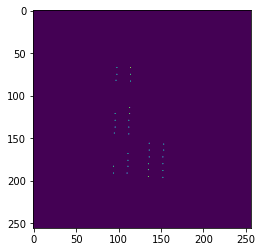

In [ ]:
plt.figure()
plt.imshow(image)
plt.imshow(mask)

## Loss plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
val_los = pd.read_csv('val_loss_1.csv')
train_los = pd.read_csv('train_loss_1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'val_loss_1.csv'

<AxesSubplot:>

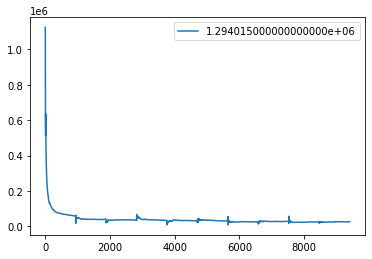

In [ ]:
train_los.plot()
plt.title('Train Loss')

Text(0.5, 1.0, 'Validation Loss')

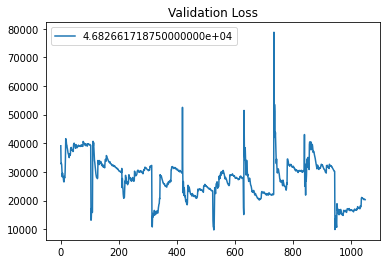

In [ ]:
val_los.plot()
plt.title('Validation Loss')